In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 5.5
fig_height = 3.5
fig_format = :svg
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/mpf/.julia/dev/KLLS/data"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| echo: false
#| code-fold: true
#| code-summary: "Import packages" 
using Revise
using KLLS
using NPZ
using Plots
using Printf
using UnPack
using LinearAlgebra

Precompiling KLLS


  ✓ ArrayInterface
  ✓ OffsetArrays


  ✓ OffsetArrays → OffsetArraysAdaptExt
  ✓ ArrayInterface → ArrayInterfaceStaticArraysCoreExt


  ✓ ArrayInterface → ArrayInterfaceReverseDiffExt


  ✓ StaticArrayInterface


  ✓ StaticArrayInterface → StaticArrayInterfaceStaticArraysExt


  ✓ StaticArrayInterface → StaticArrayInterfaceOffsetArraysExt


  ✓ CloseOpenIntervals
  ✓ LayoutPointers


  ✓ VectorizationBase


  ✓ SLEEFPirates


  ✓ LoopVectorization


  ✓ LoopVectorization → SpecialFunctionsExt


  ✓ LoopVectorization → ForwardDiffExt


  ✓ Octavian


        Info Given KLLS was explicitly requested, output will be shown live 


  ✓ KLLS


  ✓ Octavian → ForwardDiffExt
  18 dependencies successfully precompiled in 21 seconds. 202 already precompiled.
  1 dependency had output during precompilation:
┌ KLLS
│  [Output was shown above]
└  


In [3]:
#| output: false 
data = npzread("PhysicsData.npz", ["A", "b", "x0"])
@unpack A, b, x0 = data
klprob = KLLSData(A, b)

KLLS Data with 50 rows and 400 columns


In [4]:
stats = map(exp10.(range(-16, stop=-5, length=3))) do λ
          klprob.λ = λ
          p, y, stats = newtoncg(klprob)
          (λ=λ, p=p, iters=stats.iter, ∇dNrm=stats.dual_feas)
        end;

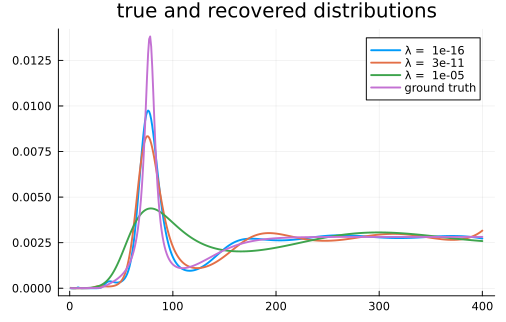

In [5]:
lab = hcat([@sprintf("λ = %6.0e", λ) for λ in getfield.(stats, :λ)]...)
default(lw=2, title="true and recovered distributions")
plot(getfield.(stats, :p), label=lab)
plot!(x0, label="ground truth")

In [6]:
#| echo: true
#| output: false 
klprob.λ = 0.0
p, y, stats = newtoncg(klprob, atol=1e-12, rtol=1e-12, verbose=0)

([3.894065176217853e-6, 3.180505256066529e-6, 3.1720140220063004e-6, 4.41181239434761e-6, 6.72511873871519e-6, 8.991344504572124e-6, 9.576526041814285e-6, 8.275166089127473e-6, 6.30720503838299e-6, 4.6912044079238975e-6  …  0.0028199901865758317, 0.0028222622166238507, 0.0028242665625057123, 0.002825900667562015, 0.002827050914411753, 0.002827592227349394, 0.0028273877298014842, 0.002826288515478534, 0.0028241335161905434, 0.002820749522105032], [-531.0553433910251, 18196.42179279422, -273353.47651526803, 2.357457753456807e6, -1.2787824066865215e7, 4.464758634823831e7, -9.683158296492718e7, 1.1079611595350067e8, -1.3649463360832307e7, -9.82149222123983e7  …  -6.161910814464235e7, -9.405588626866904e7, -1.0022427129720576e8, -7.568230530767602e7, -2.3887521126022264e7, 4.2423343260868415e7, 1.0065008259723641e8, 1.185110242000874e8, 5.4899179665108375e7, -1.3871961001427668e8], "Execution stats: maximum elapsed time")

           rms(p-x0):    3.35e-04
           rms(Ap-b):    2.52e-10
          Solve time:   30.000023
Number of iterations:      196578


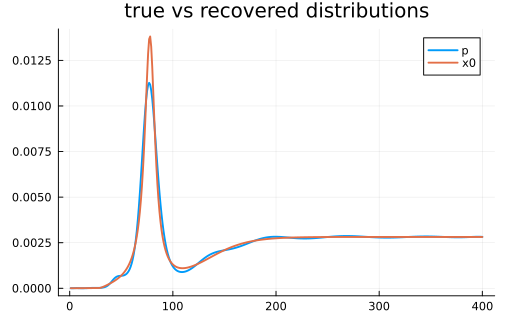

In [7]:
m, n = size(A)
@printf("%20s: %11.2e\n", "rms(p-x0)", norm(p - x0)/√n)
@printf("%20s: %11.2e\n", "rms(Ap-b)", norm(A*p - b)/√m)
@printf("%20s: %11f\n", "Solve time", stats.elapsed_time)
@printf("%20s: %11d\n", "Number of iterations", stats.iter)
plot([p x0], lab=["p" "x0"], title="true vs recovered distributions")